In [82]:
import torch
from torch.distributions import Normal
from sbi.inference import NPE
from sbi.analysis import pairplot
import numpy as np
import matplotlib.pyplot as plt
import scipy

Below we implement NPE from the SBI package to run SBI on the following model

$$x \sim N(\mu, 0.5^2)$$

$$\mu \sim N(2,1^2)$$

In [83]:
def model(mu):
    x = mu + 0.5 * torch.randn_like(mu)
    return x.view(-1,1)


In [84]:
prior = Normal(1.0,np.sqrt(2))
prior

Normal(loc: 1.0, scale: 1.4142135381698608)

In [85]:
mu.shape

torch.Size([2000, 1])

In [ ]:
inference = NPE(prior=prior)
num_simulations = 2000
mu = prior.sample((num_simulations,1))
x = model(mu)
inference = inference.append_simulations(mu, x)
density_estimator = inference.train()
posterior = inference.build_posterior()


/Users/Lieve/Documents/Masters Project/sbi_venv/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 63 epochs.

In [78]:
observation = torch.tensor([2.5]) # Observed data
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

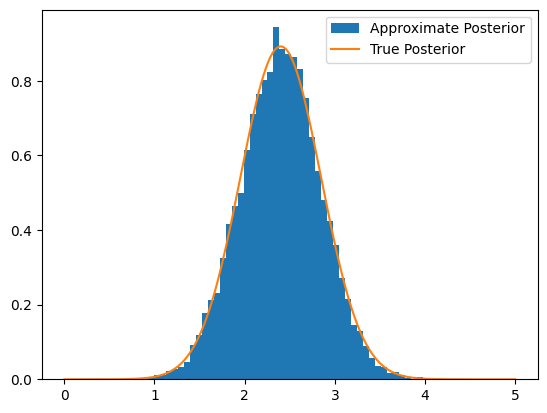

In [110]:
fig, ax = plt.subplots()
# Plot histogram of NPE samples
ax.hist(samples.detach().numpy().flatten(), density=True, bins=50, label="Approximate Posterior")
# Plot true analytical posterior
ax.plot(np.linspace(0,5,200), scipy.stats.norm.pdf(np.linspace(0,5,200), (4*observation+2)/5, np.sqrt(1/5)), label="True Posterior")
plt.legend()

In [105]:
help(posterior.sample)

Help on method sample in module sbi.inference.posteriors.direct_posterior:

sample(sample_shape: Union[torch.Size, Tuple[int, ...]] = torch.Size([]), x: Optional[torch.Tensor] = None, max_sampling_batch_size: int = 10000, sample_with: Optional[str] = None, show_progress_bars: bool = True) -> torch.Tensor method of sbi.inference.posteriors.direct_posterior.DirectPosterior instance
    Return samples from posterior distribution $p(\theta|x)$.
    
    Args:
        sample_shape: Desired shape of samples that are drawn from posterior. If
            sample_shape is multidimensional we simply draw `sample_shape.numel()`
            samples and then reshape into the desired shape.
        sample_with: This argument only exists to keep backward-compatibility with
            `sbi` v0.17.2 or older. If it is set, we instantly raise an error.
        show_progress_bars: Whether to show sampling progress monitor.



In [119]:
def npe_sbi(model, prior, posterior, num_sbi_runs=100, num_samples=100):
    ranks = []
    for i in range(num_sbi_runs):
        prior_sample = prior.sample() # Sample from prior. Returns tensor(number)
        simulated_datapoint = model(prior_sample) # Simulate a datapoint from the model given the prior sample. Returns tensor([[number]])
        posterior_samples = posterior.sample((num_samples,), x=simulated_datapoint, show_progress_bars=False) # Numpy array of (population_size, ) samples.
        rank = torch.sum(prior_sample.item() * torch.ones_like(posterior_samples) > posterior_samples) # Rank statistic
        ranks.append(float(rank))
    plt.hist(np.array(ranks)/num_samples, label="SBC rank histogram")
    plt.xlim(0, 1)
    plt.xlabel("Rank")
    plt.legend()
    plt.show()
    return ranks


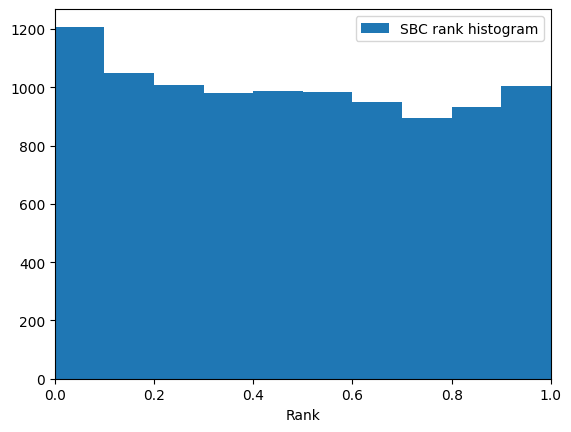

[93.0,
 367.0,
 407.0,
 159.0,
 936.0,
 988.0,
 138.0,
 643.0,
 654.0,
 850.0,
 266.0,
 553.0,
 895.0,
 653.0,
 158.0,
 794.0,
 14.0,
 190.0,
 955.0,
 321.0,
 232.0,
 891.0,
 309.0,
 101.0,
 158.0,
 95.0,
 429.0,
 652.0,
 733.0,
 65.0,
 185.0,
 196.0,
 627.0,
 767.0,
 221.0,
 571.0,
 571.0,
 322.0,
 524.0,
 565.0,
 779.0,
 940.0,
 236.0,
 355.0,
 326.0,
 34.0,
 895.0,
 259.0,
 68.0,
 85.0,
 142.0,
 4.0,
 141.0,
 555.0,
 342.0,
 487.0,
 308.0,
 158.0,
 791.0,
 16.0,
 859.0,
 364.0,
 685.0,
 111.0,
 898.0,
 681.0,
 470.0,
 325.0,
 305.0,
 914.0,
 13.0,
 243.0,
 725.0,
 845.0,
 420.0,
 89.0,
 819.0,
 560.0,
 211.0,
 642.0,
 336.0,
 482.0,
 873.0,
 926.0,
 343.0,
 890.0,
 268.0,
 865.0,
 677.0,
 882.0,
 295.0,
 495.0,
 367.0,
 226.0,
 713.0,
 848.0,
 682.0,
 39.0,
 460.0,
 420.0,
 188.0,
 398.0,
 434.0,
 713.0,
 119.0,
 366.0,
 253.0,
 182.0,
 249.0,
 966.0,
 366.0,
 782.0,
 948.0,
 397.0,
 605.0,
 440.0,
 794.0,
 123.0,
 0.0,
 945.0,
 118.0,
 446.0,
 485.0,
 925.0,
 780.0,
 392.0,
 778.0,

In [120]:
npe_sbi(model, prior, posterior, num_sbi_runs=10000, num_samples=1000)